# Imports

In [110]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
import scipy as sp
import seaborn as sns
from joblib import dump, load
import random
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
# from jupyterthemes import jtplot
# jtplot.style()

# Processing Scores - Lexicon 1

Si calcolano qua gli score dei 3 diversi metodi, e li si va a normalizzare.

In [94]:
Results_df = pd.DataFrame()

In [95]:
# Open the different models
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

## No Propagation

In [96]:
# Load as dictionary the refined lexicon
with open("./lexicon/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

In [97]:
models_propagation_none = [{word: 
                       (lexicon_refined[word]+1)/2
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_none)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [98]:
models_score_norm_none = {k: ((v - models_score_none["Wikipedia"])
     / max([abs(value - models_score_none["Wikipedia"] )
            for value in models_score_none.values()]))                        
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])}

In [99]:
Results_df = pd.DataFrame.from_dict(models_score_norm_none, 
                                    orient='index', 
                                    columns=['No Induction'])

## Nicoli Logistic

In [100]:
inducer = load("./ML_models/Nicoli_logistic.joblib")

In [101]:
# models_propagation_nicoli = [{word: 
#                        (inducer.predict([model.wv[word]])[0] + 1)/2
#   for word in model.wv.vocab} for model in slices.values()]
models_propagation_nicoli = [{word: 
                       (inducer.predict_proba([model.wv[word]])[0][1])
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_nicoli = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_nicoli)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 vocab_counts_nicoli)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_nicoli = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_nicoli, 
                                            vocab_counts_abs)}

In [102]:
models_score_nicoli_norm = {k: ((v - models_score_nicoli["Wikipedia"])
          / max([abs(value - models_score_nicoli["Wikipedia"])
            for value in models_score_nicoli.values()]))
 for k, v in sorted(models_score_nicoli.items(), key=lambda item: item[1])}

In [103]:
Results_df = pd.concat([Results_df, 
           pd.DataFrame.from_dict(models_score_nicoli_norm, 
                                    orient='index', 
                                    columns=['Nicoli Logistic'])],
         axis = 1, 
         join = 'inner')

## Hamilton

In [104]:
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations/*.csv')}

In [105]:
vocab_counts_Hamilton = {model_name: {row["Words"]: 
                      model.wv.vocab[row["Words"]].count * row["Labels"]
                for index, row in propagations[model_name].iterrows()} 
                for model, model_name in zip(slices.values(), 
                                             slices)}

# This is just the sum of all words in the corpus
vocab_counts_abs = {model_name: {word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_name in zip(slices.values(), 
                                                 slices)}
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: 
                         (sum(vocab_counts_Hamilton[name].values())
                          /(sum(vocab_counts_abs[name].values())))
                         for name in slices}

In [106]:
models_score_Hamilton_norm = {k: ((v - models_score_Hamilton["Wikipedia"])
    / max([abs(value - models_score_Hamilton["Wikipedia"] )
            for value in models_score_Hamilton.values()]))
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

In [107]:
Results_df = pd.concat([Results_df, 
           pd.DataFrame.from_dict(models_score_Hamilton_norm, 
                                    orient='index', 
                                    columns=['Hamilton'])],
         axis = 1, 
         join = 'inner')

## Visualizations

In [108]:
Results_df["Index"] = Results_df.index

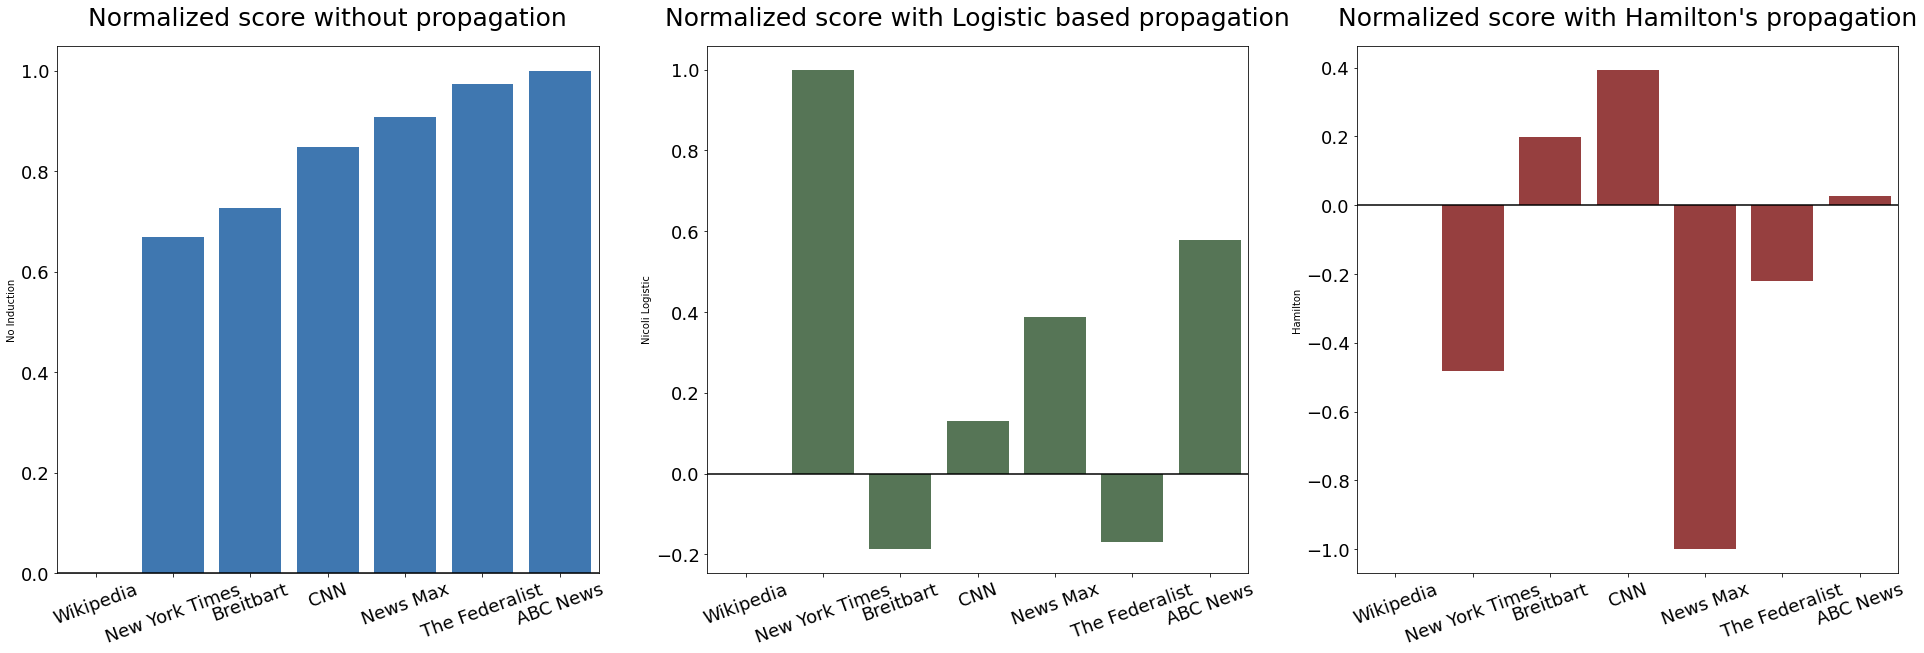

In [115]:
FONTSIZE = 25
FONTSIZE_2 = 18
PAD = 20
plt.figure(figsize=(33,33))

plt.subplot(331)
sns.barplot(x="Index", y="No Induction", 
            data=Results_df, 
            color='#2C77C3', )
plt.title("Normalized score without propagation", 
          fontsize=FONTSIZE,
         pad = PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.subplot(332)
sns.barplot(x="Index", y="Nicoli Logistic", data=Results_df, color='#517A51')
plt.title("Normalized score with Logistic based propagation", 
          fontsize=FONTSIZE, 
          pad=PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.subplot(333)
sns.barplot(x="Index", y="Hamilton", data=Results_df, color='#A43131')
plt.title("Normalized score with Hamilton's propagation", 
          fontsize=FONTSIZE,
         pad = PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.savefig("./visualizations/barplots.pdf")
plt.show()

# Processing Scores - Lexicon 2

Si calcolano qua gli score dei 3 diversi metodi, e li si va a normalizzare.

In [52]:
Results_df = pd.DataFrame()

In [53]:
# Open the different models
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

## No Propagation

In [54]:
# Load as dictionary the refined lexicon
with open("./lexicon_2/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

In [55]:
models_propagation_none = [{word: 
                       (lexicon_refined[word]+1)/2
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_none)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [56]:
models_score_norm_none = {k: ((v - models_score_none["Wikipedia"])
     / max([abs(value - models_score_none["Wikipedia"] )
            for value in models_score_none.values()]))                        
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])}

In [57]:
Results_df = pd.DataFrame.from_dict(models_score_norm_none, 
                                    orient='index', 
                                    columns=['No Induction'])

## Nicoli Logistic

In [58]:
inducer = load("./ML_models/Nicoli_logistic_2.joblib")

In [59]:
models_propagation_nicoli = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_nicoli = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_nicoli)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 vocab_counts_nicoli)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_nicoli = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_nicoli, 
                                            vocab_counts_abs)}

In [60]:
models_score_nicoli_norm = {k: ((v - models_score_nicoli["Wikipedia"])
          / max([abs(value - models_score_nicoli["Wikipedia"])
            for value in models_score_nicoli.values()]))
 for k, v in sorted(models_score_nicoli.items(), key=lambda item: item[1])}

In [61]:
Results_df = pd.concat([Results_df, 
           pd.DataFrame.from_dict(models_score_nicoli_norm, 
                                    orient='index', 
                                    columns=['Nicoli Logistic'])],
         axis = 1, 
         join = 'inner')

## Hamilton

In [62]:
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations_2/*.csv')}

In [63]:
vocab_counts_Hamilton = {model_name: {row["Words"]: 
                      model.wv.vocab[row["Words"]].count * row["Labels"]
                for index, row in propagations[model_name].iterrows()} 
                for model, model_name in zip(slices.values(), 
                                             slices)}

# This is just the sum of all words in the corpus
vocab_counts_abs = {model_name: {word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_name in zip(slices.values(), 
                                                 slices)}
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: 
                         (sum(vocab_counts_Hamilton[name].values())
                          /(sum(vocab_counts_abs[name].values())))
                         for name in slices}

In [64]:
models_score_Hamilton_norm = {k: ((v - models_score_Hamilton["Wikipedia"])
    / max([abs(value - models_score_Hamilton["Wikipedia"] )
            for value in models_score_Hamilton.values()]))
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

In [65]:
Results_df = pd.concat([Results_df, 
           pd.DataFrame.from_dict(models_score_Hamilton_norm, 
                                    orient='index', 
                                    columns=['Hamilton'])],
         axis = 1, 
         join = 'inner')

## Visualizations

In [66]:
Results_df["Index"] = Results_df.index

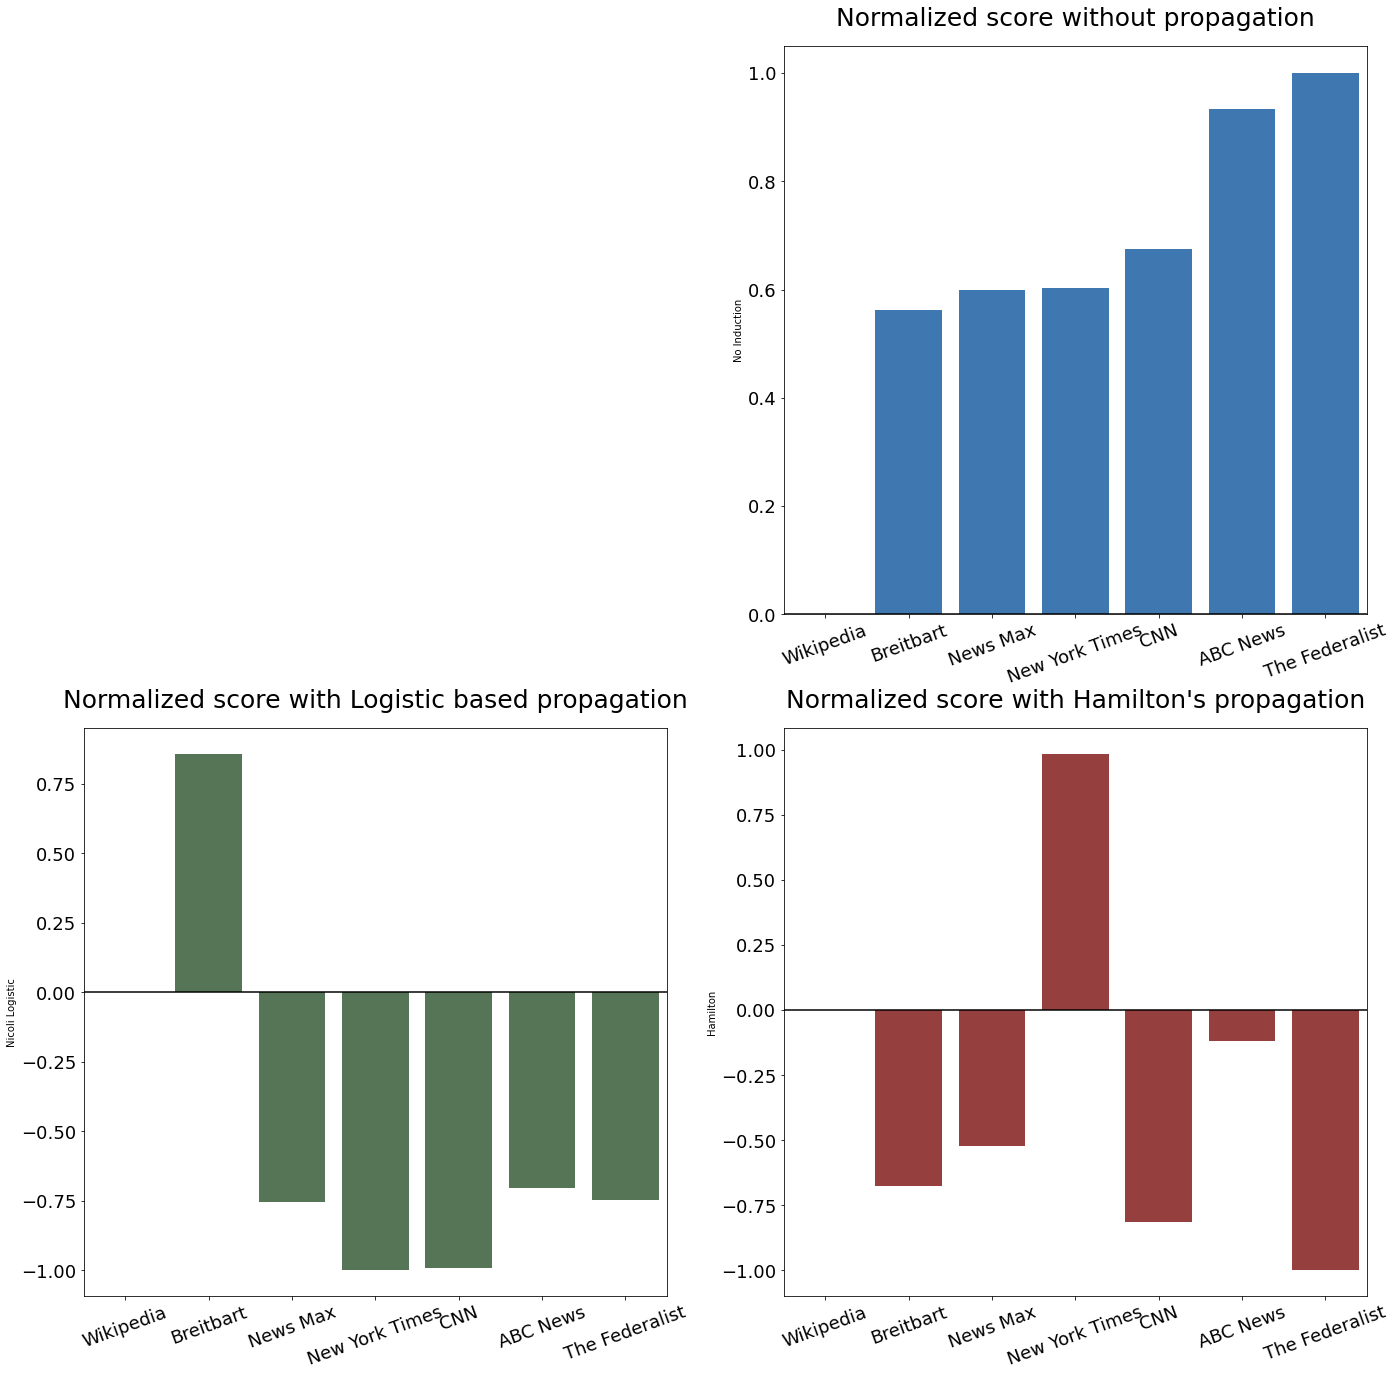

In [67]:
FONTSIZE = 25
FONTSIZE_2 = 18
PAD = 20
plt.figure(figsize=(23,23))

plt.subplot(222)
sns.barplot(x="Index", y="No Induction", 
            data=Results_df, 
            color='#2C77C3', )
plt.title("Normalized score without propagation", 
          fontsize=FONTSIZE,
         pad = PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.subplot(223)
sns.barplot(x="Index", y="Nicoli Logistic", data=Results_df, color='#517A51')
plt.title("Normalized score with Logistic based propagation", 
          fontsize=FONTSIZE, 
          pad=PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.subplot(224)
sns.barplot(x="Index", y="Hamilton", data=Results_df, color='#A43131')
plt.title("Normalized score with Hamilton's propagation", 
          fontsize=FONTSIZE,
         pad = PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.savefig("./visualizations/barplots_2.pdf")
plt.show()

# Processing Scores - Without Wiki

Si calcolano qua gli score dei 3 diversi metodi, e li si va a normalizzare.

In [82]:
Results_df = pd.DataFrame()

In [83]:
# Open the different models
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models_3/*.model')}

## No Propagation

In [84]:
# Load as dictionary the refined lexicon
with open("./lexicon_3/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

In [85]:
models_propagation_none = [{word: 
                       (lexicon_refined[word]+1)/2
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_none)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [86]:
models_score_norm_none = {k: ((v - min(models_score_none.values()))
     / (max(models_score_none.values()) - min(models_score_none.values())))
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])}

In [87]:
Results_df = pd.DataFrame.from_dict(models_score_norm_none, 
                                    orient='index', 
                                    columns=['No Induction'])

## Nicoli Logistic

In [88]:
inducer = load("./ML_models/Nicoli_logistic_without_Wiki.joblib")

In [89]:
models_propagation_nicoli = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_nicoli = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_nicoli)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 vocab_counts_nicoli)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_nicoli = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_nicoli, 
                                            vocab_counts_abs)}

In [90]:
models_score_nicoli_norm = {k: ((v - min(models_score_nicoli.values()))
     / (max(models_score_nicoli.values()) - min(models_score_nicoli.values())))
 for k, v in sorted(models_score_nicoli.items(), 
                    key=lambda item: item[1])}

In [91]:
Results_df = pd.concat([Results_df, 
           pd.DataFrame.from_dict(models_score_nicoli_norm, 
                                    orient='index', 
                                    columns=['Nicoli Logistic'])],
         axis = 1, 
         join = 'inner')

## Visualizations

In [92]:
Results_df["Index"] = Results_df.index

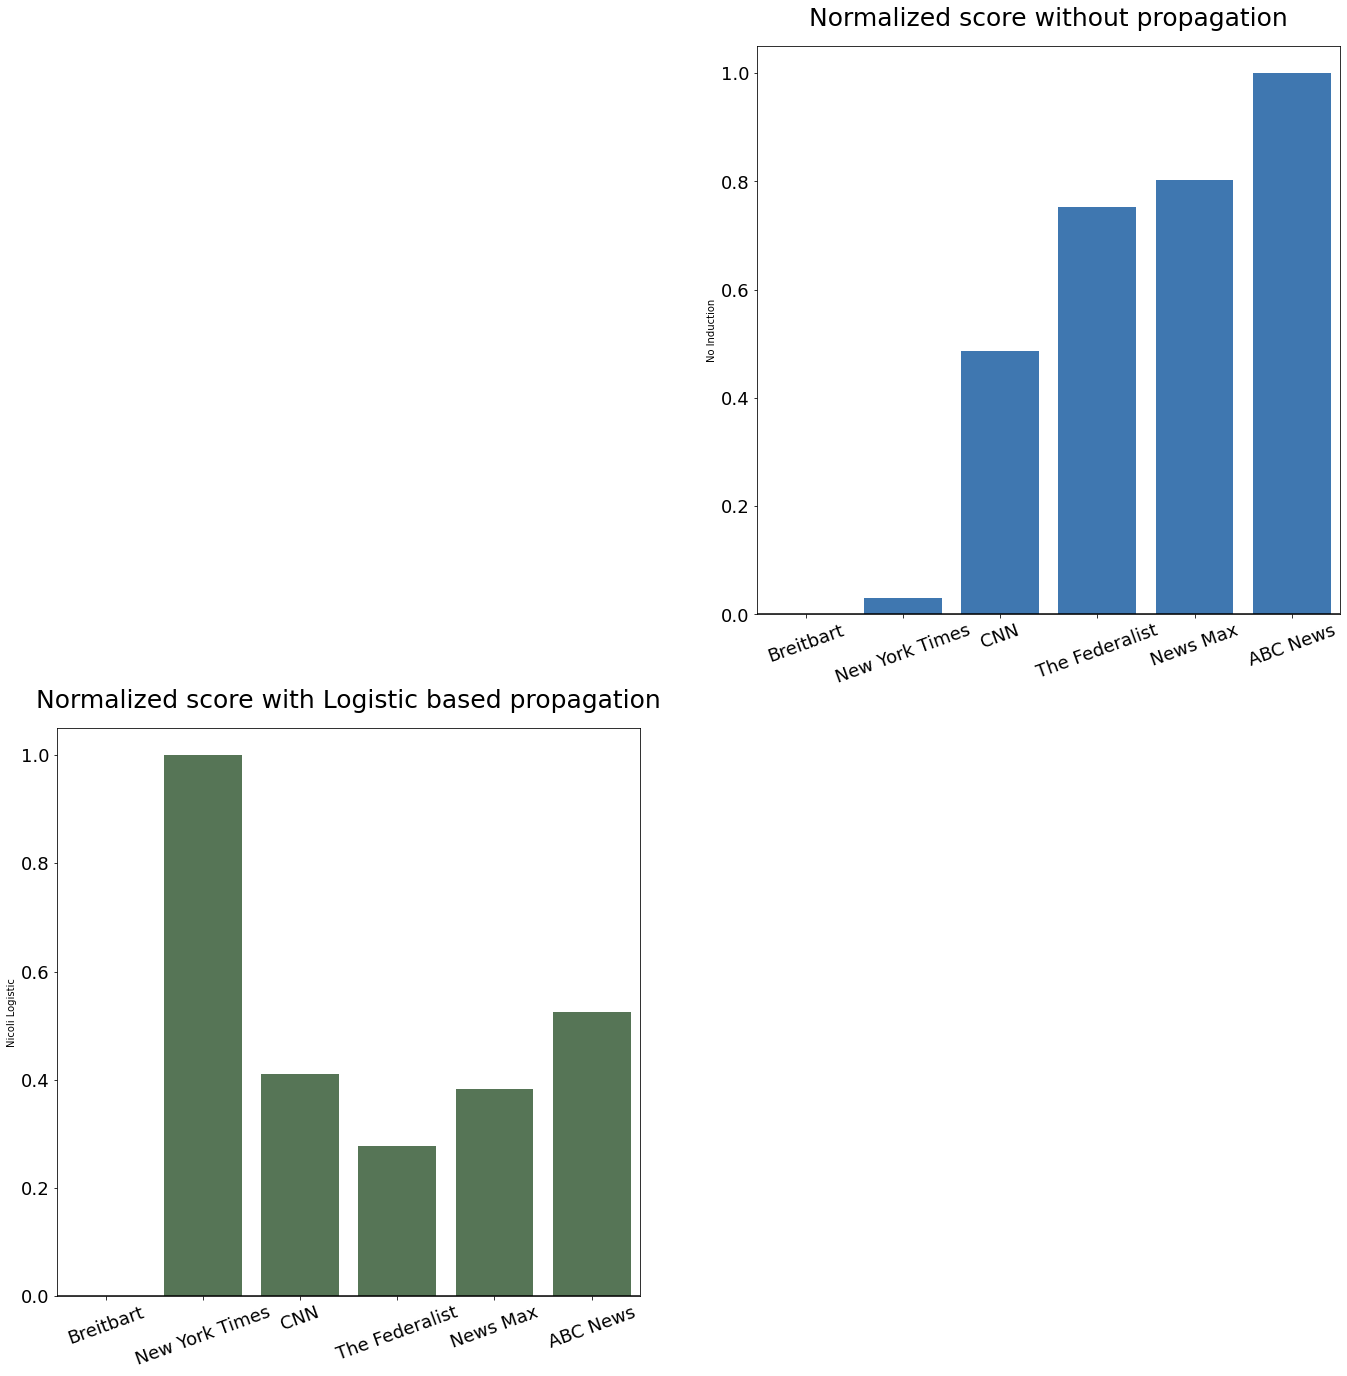

In [93]:
FONTSIZE = 25
FONTSIZE_2 = 18
PAD = 20
plt.figure(figsize=(23,23))

plt.subplot(222)
sns.barplot(x="Index", y="No Induction", 
            data=Results_df, 
            color='#2C77C3', )
plt.title("Normalized score without propagation", 
          fontsize=FONTSIZE,
         pad = PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.subplot(223)
sns.barplot(x="Index", y="Nicoli Logistic", data=Results_df, color='#517A51')
plt.title("Normalized score with Logistic based propagation", 
          fontsize=FONTSIZE, 
          pad=PAD)
plt.tick_params(labelsize=FONTSIZE_2)
plt.xlabel("", fontsize=FONTSIZE)
plt.axhline(0, color='black')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)

plt.savefig("./visualizations/barplots_without_wiki.pdf")
plt.show()